In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysrt
import os
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer

In [ ]:
model_name = "facebook/bart-large-cnn"  
class BartForRegression(torch.nn.Module):
    def __init__(self):
        super(BartForRegression, self).__init__()
        self.bart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
        self.dropout = torch.nn.Dropout(0.1)
        self.regression_head = torch.nn.Linear(self.bart_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bart_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        hidden_state = outputs.decoder_hidden_states[-1]
        regression_output = self.regression_head(self.dropout(hidden_state[:, 0]))

        return regression_output.squeeze(-1)

In [ ]:
model = BartForRegression()

In [ ]:
model.load_state_dict(torch.load('BartForRegression.pth'))

In [ ]:
def predict_(custom_list):
  result = []
  tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
  model.eval()
  for i in range(len(custom_list)):
      inputs = tokenizer(custom_list[i], padding='max_length', truncation=True, return_tensors='pt',max_length=128)

      input_ids = inputs['input_ids']
      attention_mask = inputs['attention_mask']


      with torch.no_grad():
          regression_output = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)

      predicted_score = regression_output.item()
      result.append(predicted_score)

  return result

# Predicting Ratings on YouTube Channels

In [2]:
YoutubeTranscrips= pd.read_csv('All_Video_Transcripts/videos_data_with_transcript.csv')

Predicting ratings for YouTube videos

In [3]:
all_YT_transcrips = []
for i in range(len(YoutubeTranscrips['Transcript'])):
    all_YT_transcrips.append(str(YoutubeTranscrips['Transcript'][i]))

In [ ]:
results_all = predict_(all_YT_transcrips)

Drop null values

In [5]:
YoutubeTranscrips['results'] = results_all
updated_withoutnull_yt_transcripts = YoutubeTranscrips.dropna(subset=['Transcript'])

In [6]:
def classify_results(custom_list,updated_withoutnull_yt_transcripts):
    results = []
    for i in range(len(custom_list)):
        channel_id = custom_list[i]
        for ind in updated_withoutnull_yt_transcripts.index:
            if updated_withoutnull_yt_transcripts['channel_id'][ind] == channel_id:
                results.append(updated_withoutnull_yt_transcripts['results'][ind])  
    return results

# CDF Plot- YouTube Kids Video Ratings vs Disney Movie Ratings

**Extracting subtitles from Disney Movie**

In [ ]:
all_Movie_Name=[]
all_transcripts = []

path_of_the_directory = 'DisneyMovieSubtitlesDataset/Subtitles'
ext = ('.srt')
for files in os.listdir(path_of_the_directory):
    if files.endswith(ext):
        # print(files)  
        # video_id = files
        # f = open('DisneyMovieSubtitlesDataset/Subtitles/{}'.format(files))
        all_Movie_Name.append(files)
        subs = pysrt.open('DisneyMovieSubtitlesDataset/Subtitles/{}'.format(files),encoding= 'unicode_escape')
        temp_sub = ''
        for sub in subs:
            # print(sub.text)
            # print()
            temp_sub = temp_sub + sub.text
        if temp_sub == '':
            with open('DisneyMovieSubtitlesDataset/Subtitles/{}'.format(files),encoding= 'unicode_escape') as myfile:
                data = myfile.read()
            temp_sub = data
        all_transcripts.append(temp_sub)       
    else:
        continue

In [ ]:
def predict_1024(custom_list):
  result = []
  tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
  model.eval()
  for i in range(len(custom_list)):
      inputs = tokenizer(custom_list[i], padding='max_length', truncation=True, return_tensors='pt',max_length=1024)

      input_ids = inputs['input_ids']
      attention_mask = inputs['attention_mask']


      with torch.no_grad():
          regression_output = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)

      predicted_score = regression_output.item()
      result.append(predicted_score)

  return result

In [ ]:
results_disney = predict_1024(all_transcripts) # Used max_length as 1024 instead of 128

In [17]:
# results_disney_ = pd.read_csv('results_disney_final.csv')
# results_disney = results_disney_['results_disney_final'].tolist()

In [19]:
results_all_without_null = updated_withoutnull_yt_transcripts['results']

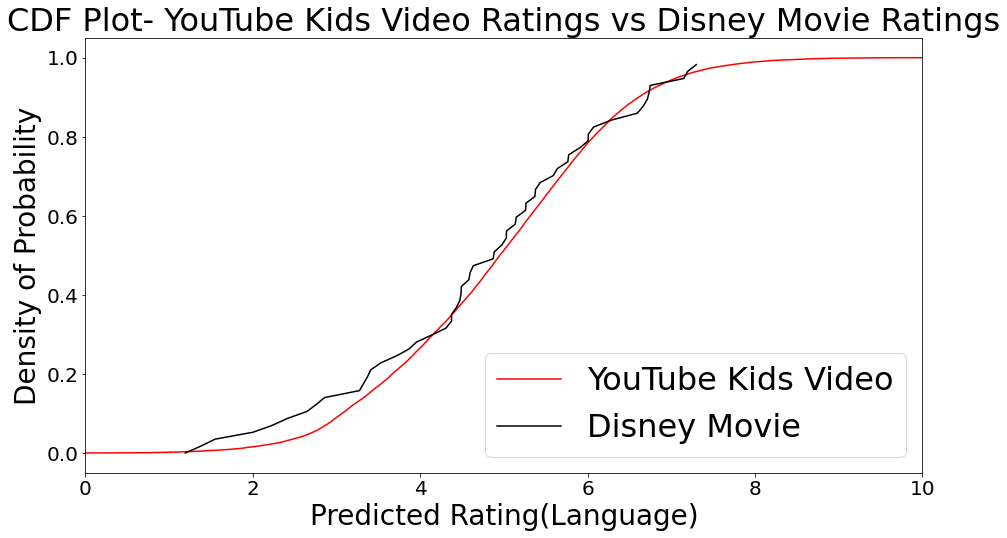

In [20]:
%matplotlib inline
  
# No of data points used
N1 = len(results_all_without_null)  
N2 = len(results_disney) 
  
# normal distribution
data1 = np.random.randn(N1)
data2 = np.random.randn(N2)
  
# sort the data in ascending order
x1 = np.sort(results_all_without_null)
x2 = np.sort(results_disney)
  
# get the cdf values of y
y1 = (np.arange(N1) / float(N1))

y2 = (np.arange(N2) / float(N2)) 
  
# plotting
plt.figure(figsize=(15, 8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([0, 10])
plt.xlabel('Predicted Rating(Language)',fontsize=28)
plt.ylabel('Density of Probability',fontsize=28)
plt.title('CDF Plot- YouTube Kids Video Ratings vs Disney Movie Ratings',fontsize=32)
plt.plot(x1, y1,color='r',label='YouTube Kids Video')
plt.plot(x2, y2,color='k',label='Disney Movie')
plt.legend(fontsize = '32',loc='lower right')
plt.show()

# CDF Plot- YouTube Kids Video Ratings Comparison by Races

**Custom Lists containing YouTube ChannelIds by different races**

In [7]:
Mixed_Race = ['UCBnZ16ahKA2DZ_T5W0FPUXg','UC7Pq3Ko42YpkCB_Q4E981jw','UCbCmjCuTUZos6Inko4u57UQ','UC4NALVCmcmL5ntpV0thoH6w',
        'UCsCe7SNQckiRJ6y563SIupg','UC9iBBFfq7L3ipvodSLrU8gQ','UCbmWOFTbZoDLWqG1rvFnJ0g','UC5mMf2NE17_MiTL94ihRN2w',
        'UC2VjS4B4YBTH00TE-SMD_aw','UCEJfVga185COFm1MsN4KQUA']

White = ['UChGJGhZ9SOOHvBB0Y4DOO_w','UCKcQ7Jo2VAGHiPMfDwzeRUw','UCRx3mKNUdl8QE06nEug7p6Q','UCc-2P5tCezbxegb7gxp6EXg','UCpzYfBXbEHHQHU2e89jM9Tg',
        'UC3KknIJZXRygH2pZ6MDtGbg','UCI8V0wOaigGdBpv5uk7DxxQ','UCCc1DMB-AcOssKJ7KweLXBg','UC8MR0wSTbzs5Yo7DgP04P-w','UC6LKuH7RPkvRmzS9-8URtqA',
        'UC5mMf2NE17_MiTL94ihRN2w','UChz5aEi3dfrDVC8-YJsMUDA','UCsVTvWIa3k6R32VBmMyKOsg','UCMyyXCurk6jXXOWt2eKyCgg','UCAwIKJ84zBsiuuy9DVR13mA',
        'UCGVrxaJHUQHbPSUVDZ8sUVQ','UCZA2NJWgiWtLQZPfMhhEZUQ','UCotX63w9fF1eTCjda7Ux3Rw','UCsiqlKIUDHZJVG4smMvhF4w','UC5uIZ2KOZZeQDQo_Gsi_qbQ',
        'UCGI6tdFKWbSUDSw0ceI4mLQ','UC5pJi9mLIy38m2e_u3sboKQ','UCbVGLnrXJzqwvxS9hyTsWDw','UCzGoN1TCO2uiAQWyiNrGhuw','UCTlThMcv2OFj7KfbOFhLrvg',
        'UCWCOoCApFUtccYENOYeL1uw','UCGdQ8OUs2qM0gwkaa_MtFNg','UCtvYrG5IeaYNeHDKjKJJNRA','UC8Ae-2QbWgFjgAfFMHn02Zw','UCyxe3g0khLIXRxRd3G9qSrw',
        'UCihTA5crIIdkStBXZNxmI-A','UCn3dC5Pe_PLudpWIEWL1v_w','UCXXunTfMOcUlUeHlSDxmsCQ','UC68XdlxjeqSsjoAdR3nw9Vg','UC-VrU4EkjIMkIik0-7La5OA',
        'UCJcc5qvHowxRshW9P6YZwKA','UC_nVcTv8k1SETJ1QFrwz7tA','UCaKssrpIyGDuKsuOjZhoWfg','UC157gj--r7hkPTqNu9bS72Q','UC0KchmlIoXBZSvumBr97PCQ',
        'UC_M0w5yZ5J7BxpC51NPszoQ','UCHtM7sxr5I_iSxn0ZQZoHKQ','UCx2wnld0c65HZYU3s4bUDAw','UC_Bqpta6NXh9tIlEsliARog','UCW9uCEon8IL1N1qloHVZ0fQ',
        'UCTUkvjhEGfi_QKDTYJlGtFg','UC__qAOlkSIFu8RGtr4MyV8w','UCan48A3vtMqg1gvYmHl-iVA','UCQr8lCu5qlCJsariG2UJVhA','UC9c4XvpiSs_cFWMwXO3qw6A',
        'UCDHU0rh47wAgRbI9iwVmq8g','UC-XLsUekYYS_Pv0Zhp6BDQw','UCFRSL5xMQm8egTDbGBy8icw','UC1xvP0LqUviUOxvchL5goSw']

Black = ['UCxs5IqCTpCRYd39tbfiYbKg','UCcH2mltxAje6fsAd2bqWcjQ','UCCNUEAMXWKodVu8gKww7Qng','UCnhPaQOYHqxUzmt37jsHNKw','UCGg4FUbyr4smzyKD6tscvKg',
        'UCPMtkf1FE5XLOdz7ZehUyLA','UCLaZsVGWtAbL1GPemt6HThQ','UCx0eQsDrjn-EXMWeusTh2cQ','UCaCl_YJvwRuT9tSciCavOxQ','UC-DlN8ZsnEHvshuvBOg25lw',
        'UCie2kQcTjLmz83Jy5BZgKuQ']

Animation = ['UCcdwLMPsaU2ezNSJU1nFoBQ','UCpYye8D5fFMUPf9nSfgd4bA','UCtdDvqUzY2Gdx4MuKrOQ_zA','UCMfZ_z0LUm805JOZLktl2QQ','UCbt63GNsB5wet6NO3dmhssA'
            ,'UCLx59V2UVcg767ppt8S7B6Q','UC-biucJWhM8HwjsQ96uoIUw','UCUJz3Kx_UkivcPzdAmcFAPg','UCVHO-W63u8RrXa6BAHxfLtQ','UCHSnzMeCGtVOjenB1Grnn5Q',
            'UCmKy_mpl8mCDDTTg96d7mhw','UCpQfF_qehNal4D7KpakObuA','UC7EFWpvc1wYuUwrtZ_BLi9A','UCtBOJ9bEAoMOY9keGK6p2hQ','UC5wtOwEHCG_JAIpDdkiaZ6A',
            'UCwynFfAvCF2kiRSMWiozQHg','UC0l7SdYHH6WAmXECumlKSkg','UCmKsULSe7oGtdGcv3bz-_bw','UCcUqbcfVrRSImkF0vDdgc9w',
            'UCvuXJ7jxbGakmLXgwRn88gQ','UCmumhdE_anzs3_jVgZHWndw','UCKyywickFyBGRRxbxpn7CGA','UCE8YdasdvUDlAyFdFcI-AHg','UCLJ5EBmiuSLBcQR-R6rGVHA',
            'UCxidbvHajzXm-9wBK-w8IZA','UCGu9-9FqQtXAitxkOnHzz6Q','UCfxN7O1NzZqoGBCJi6V6wpA','UC2RNg_QGZriSGQo6enPLpeQ','UC_c4psnFX-ZyCUXA_vlXpIQ',
            'UCpq1tEJYbykozES2oqwdwlw','UC8sIPIn-8vOu1181XxXF7tA','UCpbG0QvrvdpBAegtY_ebeEw','UCz0yhTJVJoN20-e5FKJhkeg','UCAxDx-4eZfkVZrHmgKNdNMA',
            'UCuLX36CLL2Lc6H4qyndFrnA']

South_Asian=['UC2VERcmMqi3vdtoQQ0ZP2sA','UCkJYEAR9ZM7hvAM-SkniJ0Q','UCuiTofxf5rE_oZoE7LVQj-g','UCbmsBnSEOyX7lI9MACnJMLw','UCDIJ0JnyFRdw-q50oHN8aHA',
            'UCDaiI5cDqAavlKToEZre9Iw','UCbj37fjb2u8eb7nK-P4US9Q']

# Others: Animals, Nature, Toys, Crafts, Education etc
Others = ['UC1THeiEwEW3N02ZmqmDKquQ','UCqKNzUHmCrvZsFDzpAR3GjA','UC3PRgO4VJJxZ6nTVHazUVKA','UC8CssPJ0drSvFQ2nAq1TKSQ','UCrZ9CtlECK_Jl92di5fCfSg',
        'UCHyIeqvhdd85GxtfWBkbEgw','UCJxd2QGa3_-j1dbGcynjAlw','UCPWPAf6QR_oAcd_nfsLwzsg','UCmwvcdwnE_mhLFqNggTclrg','UCRJEYM-APkDTxyKPtfxjptg',
        'UCJvSy1w_ubQvsEeUai3EuFQ','UCCJeWCQ6ZHcJdt50IceAVrg']

# Animation videos + White Person's Video
Animation_White = ['UCKjjmMqvuxNYw8c6knceexQ','UCLsooMJoIpl_7ux2jvdPB-Q','UCwjoPtSoNLAoX2sLBaKLYng','UCoookXUzPciGrEZEXmh4Jjg','UCfFzNEYxqsSGoiw1ojgEhjw',
                    'UCyXWYhbJomJcTUg98MR5PFA','UCFv1WlfAtdQAh1CXt70xg-g']

Animation_South_Asian = ['UCj-SWZSE0AmotGSQ3apROHw']

Animation_Black = ['UCTRNV3t2jxbkZgBjhyDv8UQ','UCxezak0GpjlCenFGbJ2mpog']

In [8]:
results_mixedrace = classify_results(Mixed_Race,updated_withoutnull_yt_transcripts)
results_white = classify_results(White,updated_withoutnull_yt_transcripts)
results_black = classify_results(Black,updated_withoutnull_yt_transcripts)
results_animation = classify_results(Animation,updated_withoutnull_yt_transcripts)
results_south_asian = classify_results(South_Asian,updated_withoutnull_yt_transcripts)
results_others = classify_results(Others,updated_withoutnull_yt_transcripts)
results_Animation_White = classify_results(Animation_White,updated_withoutnull_yt_transcripts)
results_Animation_South_Asian = classify_results(Animation_South_Asian,updated_withoutnull_yt_transcripts)
results_Animation_Black = classify_results(Animation_Black,updated_withoutnull_yt_transcripts)

In [9]:
%matplotlib inline
  
# No of data points used
N1 = len(results_white)
N2 = len(results_black)
N3 = len(results_mixedrace)
N4 = len(results_animation)
N5 = len(results_others)
N6 = len(results_south_asian)
  
# normal distribution
data1 = np.random.randn(N1)
data2 = np.random.randn(N2)
data3 = np.random.randn(N3)
data4 = np.random.randn(N4)
data5 = np.random.randn(N5)
data6 = np.random.randn(N6)
  
# sort the data in ascending order
x1 = np.sort(results_white)

x2 = np.sort(results_black)
x3 = np.sort(results_mixedrace)
x4 = np.sort(results_animation)
x5 = np.sort(results_others)
x6 = np.sort(results_south_asian)
  
# get the cdf values of y
y1 = (np.arange(N1) / float(N1))

y2 = (np.arange(N2) / float(N2)) 
y3 = (np.arange(N3) / float(N3)) 
y4 = (np.arange(N4) / float(N4)) 
y5 = (np.arange(N5) / float(N5)) 
y6 = (np.arange(N6) / float(N6))

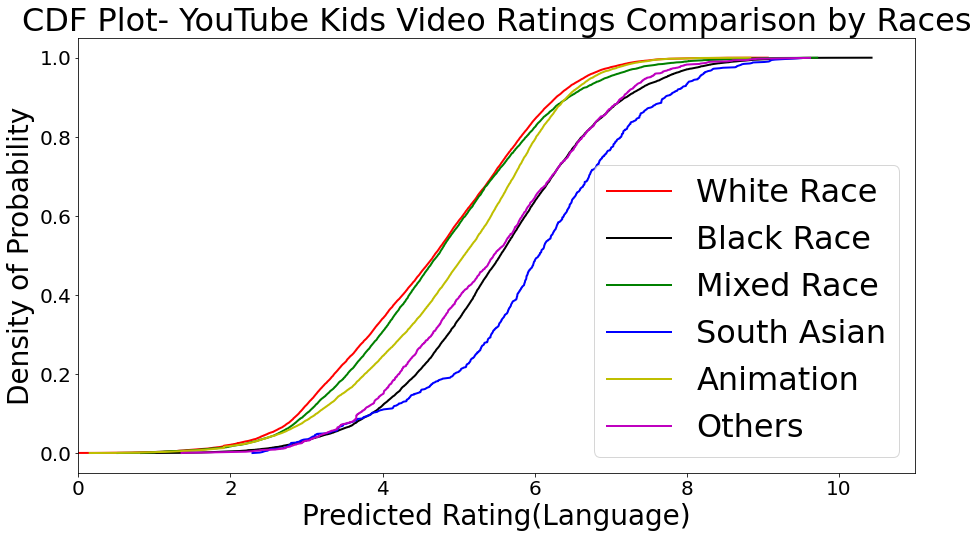

In [24]:
# plotting
plt.figure(figsize=(15, 8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([0, 11])
plt.xlabel('Predicted Rating(Language)',fontsize=28)
plt.ylabel('Density of Probability',fontsize=28)
plt.title('CDF Plot- YouTube Kids Video Ratings Comparison by Races',fontsize=32)
plt.plot(x1, y1,color='r',label='White Race',linewidth=2)
plt.plot(x2, y2,color='k',label='Black Race',linewidth=2)
plt.plot(x3, y3,color='g',label='Mixed Race',linewidth=2)
plt.plot(x6, y6,color='b',label='South Asian',linewidth=2)
plt.plot(x4, y4,color='y',label='Animation',linewidth=2)
plt.plot(x5, y5,color='m',label='Others',linewidth=2) 
plt.legend(fontsize = '32',loc='lower right')
plt.show()

# CDF Plot- Animated vs Non Animated vs Mixed YouTube Kids Videos

**Custom df containing ChannelIds by Animated, Non Animated and Others**

In [12]:
df_animated_non_animated = pd.read_csv('channels_100_animated_n_non_animated_labelled.csv')

Extracting Channel Ids to create Custom Lists for Animated, Non Animated and Others channel

In [13]:
animated_ids = df_animated_non_animated[df_animated_non_animated['is_animated'] == 'Yes']['Channel ID'].tolist()
non_animated_ids = df_animated_non_animated[df_animated_non_animated['is_animated'] == 'No']['Channel ID'].tolist()
mixed__ids = df_animated_non_animated[df_animated_non_animated['is_animated'] == 'mixed']['Channel ID'].tolist()

In [14]:
results_animated_Ids = classify_results(animated_ids,updated_withoutnull_yt_transcripts)
results_Non_animated_Ids = classify_results(non_animated_ids,updated_withoutnull_yt_transcripts)
results_mixed_animated_Ids = classify_results(mixed__ids,updated_withoutnull_yt_transcripts)

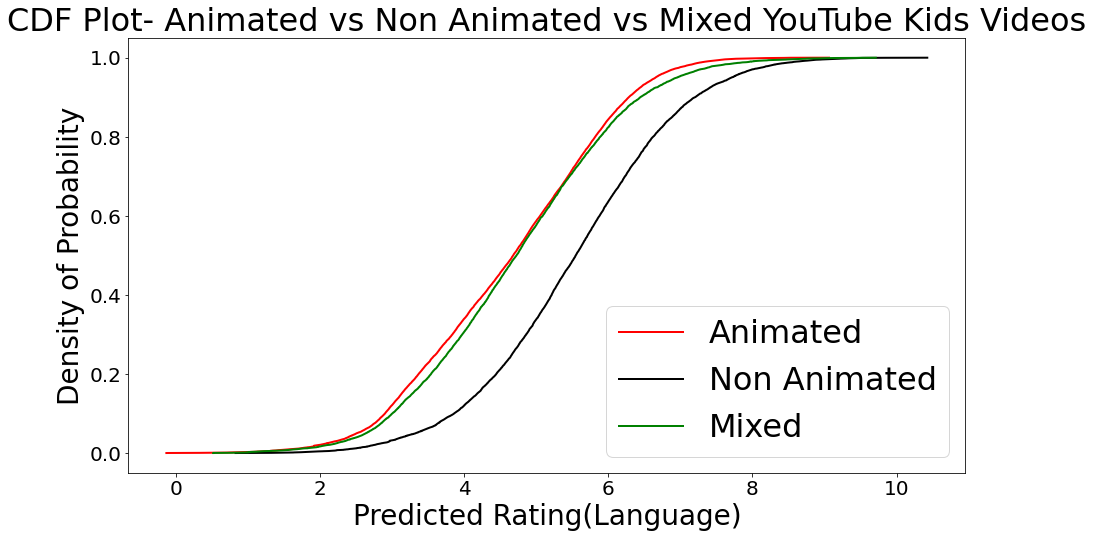

In [22]:
%matplotlib inline
  
# No of data points used
N1 = len(results_animated_Ids)  
N2 = len(results_Non_animated_Ids) 
N3 = len(results_mixed_animated_Ids)
  
# normal distribution
data1 = np.random.randn(N1)
data2 = np.random.randn(N2)
data3 = np.random.randn(N3)
  
# sort the data in ascending order
x1 = np.sort(results_animated_Ids)
x2 = np.sort(results_Non_animated_Ids)
x3 = np.sort(results_mixed_animated_Ids)
  
# get the cdf values of y
y1 = (np.arange(N1) / float(N1))
y2 = (np.arange(N2) / float(N2)) 
y3 = (np.arange(N3) / float(N3)) 
  
# plotting
plt.figure(figsize=(15, 8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Predicted Rating(Language)',fontsize=28)
plt.ylabel('Density of Probability',fontsize=28)
plt.title('CDF Plot- Animated vs Non Animated vs Mixed YouTube Kids Videos',fontsize=32)
plt.plot(x1, y1,color='r',label='Animated',linewidth=2)
plt.plot(x2, y2,color='k',label='Non Animated',linewidth=2)
plt.plot(x3, y3,color='g',label='Mixed',linewidth=2)
plt.legend(fontsize = '32',loc='lower right')
plt.show()

# Examples from predictions

In [40]:
def custom_predicted_output_details(df,i):
    print("Transcript: "+ df['Transcript'][i])
    print("videoId: " + df['video_id'][i])
    print("Predicted Rating: "+ str(df['results'][i]))

In [33]:
filtered_df = updated_withoutnull_yt_transcripts[(updated_withoutnull_yt_transcripts['results'] >= 6) & updated_withoutnull_yt_transcripts['Transcript'].str.contains('fuck', case=False)]

In [34]:
filtered_df.head()

,Unnamed: 0,video_id,channel_id,Transcript,results
33,33,dC7tUcRCS58,UCBnZ16ahKA2DZ_T5W0FPUXg,Yeah wow. Uh So fucking there was a farmer had...,8.526668
69,69,g8rX4emmI10,UCBnZ16ahKA2DZ_T5W0FPUXg,wow. Uh huh. Mhm mm mm. Ring a ring a roses fu...,6.663065
82,82,a9MOsNkWQWU,UCBnZ16ahKA2DZ_T5W0FPUXg,Oh uh huh. Yes Children. No Children. Yes Chil...,6.387364
161,161,IVrP1Q5cVQ0,UCBnZ16ahKA2DZ_T5W0FPUXg,Hi. I'm to to please click to subscribe. Don't...,6.561011
204,204,r8iGnwD8i9I,UCBnZ16ahKA2DZ_T5W0FPUXg,wow mm. What? Mhm. See G. Day Ellen. Help me. ...,6.649385


In [41]:
custom_predicted_output_details(filtered_df,913)

Transcript: So what are you guys playing with today? We're gonna play with the fucking powder candy. Yeah. Wow, that's super cool. It's great for parties. It says you can have a candy making party. Kids, I know how to open boxes really easy. Yeah, a There's strawberry strawberry woman in the Oh, yeah, these are the flavor. Okay. Strawberry. It comes with strawberry. Yeah, lemon, lemon and and all of us. It's a sour punch. Yeah. All right. Let's build this everything. Straw sticks. They looked like straws. Yeah, that's the way you put the Candies in. Okay, welcome. Stay right in. Toy from you. So with the powder, and then we're gonna eat them out with the straw. Oh, okay. So gonna fill the sour punch into the sour punch container. I'm gonna make sure I'm gonna make sure none falling out. It won't fall. Ryan. Oh. Mm hmm. Nothing. That's good. So next we have to pour in the strawberry, like one blue and one red, and it's gonna make purple. And that one's yellow. So this one is that one. T

In [44]:
filtered_df_violence = updated_withoutnull_yt_transcripts[(updated_withoutnull_yt_transcripts['results'] >= 6) & updated_withoutnull_yt_transcripts['Transcript'].str.contains('gun shot', case=False)]

In [45]:
filtered_df_violence.head()

,Unnamed: 0,video_id,channel_id,Transcript,results
12367,12367,MEXGbN5suQQ,UCoookXUzPciGrEZEXmh4Jjg,right. Oh God wow. Same idea mm. Yo been loyal...,7.418247
58494,58494,X0SEnxix7aY,UCsiqlKIUDHZJVG4smMvhF4w,what is up y'all i'm back with another video m...,7.728139
58532,58532,ZGfgGbhCyhM,UCsiqlKIUDHZJVG4smMvhF4w,what's good YouTube I'm back with another vide...,8.287715
79158,79158,yZbSCkpo4xM,UC9c4XvpiSs_cFWMwXO3qw6A,hi everyone here's another unboxing and this i...,7.807632


In [43]:
custom_predicted_output_details(filtered_df_violence,58532)

Transcript: what's good YouTube I'm back with another video man this dude official klenzrite y'all probably know I played this dude on 17 but he really thinks he's gonna beat me in this build off bro right you're not good bro you're you're actually trash dude and by sound god I'm getting books my loose coated oh I got a heavy up up everything you ready bro all right go uh 25 right you're getting bucked brown gob you're getting box breath come on let's go already already already look at you [Music] bro you almost lost me there didn't you [Music] but how are you ready you're annoying bruh he bugs me once you really think I'm gonna let you boss me twice bro you're bad bro you're bad alright I'm beating you this time right you're you're you hear me on Geo on gob on meeting you bro gob bro yeah look at you you're trash bro I'm getting my little bro relax relax dude alright Brad let's go dude I know I know I thought BOTS last time but I mean I was lagging the entire time so I'm plane of ligh

In [55]:
custom_predicted_output_details(updated_withoutnull_yt_transcripts,62604)

Transcript: declare it on the door your freedom rate and patriotic voices never give up you represent today these rebels need to be taught a lesson will you let them burn down the town all companies march to the bridge but hold your fire not fire on the Kings troops unless were fired upon first it's a wonder you two are still standing April 19 1775 dear mother the people of the colonies are stubbornly independent taxes did we ever say none more so than here in Massachusetts our brothers they are bent on governing themselves and now to cry the same redcoats for just 12 years ago help them win the French and Indian War cousin tom he's serving under general gage marching on Concord what must he be thinking right now cousin Tom you are the answer are you up already say what are you doing I'm going to find my cousin what he's thinking is what the people of these colonies need to know a lieutenants perspective on the soldiers role in keeping peace there won't be peace until we have the same 